In [53]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

""" some basic packages and settings to show images inline """
import numpy as np
import torch

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

""" Controls for figure sizes to change """
import matplotlib
plt.rcParams.update({'errorbar.capsize': 1})
# VoMi: Configure figure fonts
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['cmr10']  # This sets the Computer Modern Roman font
matplotlib.rcParams['text.usetex'] = False  # Ensure LaTeX is not being used for rendering
matplotlib.rcParams['axes.unicode_minus'] = False

# Alternatively, you can specify other font properties if needed
matplotlib.rcParams['font.size'] = 14  # Set the global font size
matplotlib.rcParams['axes.titlesize'] = 14  # Set the axes title font size
matplotlib.rcParams['axes.labelsize'] = 12  # Set the axes labels font size
matplotlib.rcParams['xtick.labelsize'] = 12  # Set the x-tick labels font size
matplotlib.rcParams['ytick.labelsize'] = 12  # Set the y-tick labels font size
matplotlib.rcParams['legend.fontsize'] = 12  # Set the legend font size

""" Lab support code """
from lab import test_set, load_net, distances, get_features, evaluate_mAP

def save_jpg(file_name):
    plt.savefig(file_name, bbox_inches='tight', dpi=199, pad_inches=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Retrieval

In [54]:
# VoMi: for triplet model you will need to implement 'triplet_loss' and 'train_triplet' in lab.py
# VoMi: for smoothAP model you will need to implement 'smooth_AP_loss' and 'train_smooth_AP' in lab.py

# net = load_net('./models/net_class.pl') # load pretrained classification network
# net = load_net('./models/net_triplet.pl') # load network trained with triplet loss
# net = load_net('./models/net_smoothAP.pl') # load network trained with smoothAP loss

### Show nearest neighbours

In [55]:
np.random.seed(0)
torch.manual_seed(0)

print(f'{len(test_set) = }')

query_idxs = np.random.choice(len(test_set), size=10, replace=False)
print(f'{query_idxs = }')

# indices of query images


# Not really needed for anything, everything is calculated in show_nearest


# extract features for all test_samples
#from lab import get_features, distances
#loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
#features, labels = get_features(net, test_set)

len(test_set) = 1000
query_idxs = array([993, 859, 298, 553, 672, 971,  27, 231, 306, 706])


In [56]:
def show_nearest(test_set, labels, query_idxs, dists):
    # show 50 nearest retrived images for every query in query_idxs
    N = 50

    f, axarr = plt.subplots(len(query_idxs), 1, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(16,4), dpi=200)

    num_correct = np.zeros_like(query_idxs)

    for i, qidx in enumerate(query_idxs):
        ax = axarr[i]
        d = dists[qidx, :]
        ds = torch.argsort(d)[:N+1]     # N+1 because the query image is retrieved as well
        img = np.ones((28, 28*(N+1)+10, 3))
        sid = 0
        qimg = ((test_set[qidx][0] * 0.5) + 0.5).cpu().detach().numpy()
        img[:, sid:sid+28, :] = np.stack((qimg, qimg, qimg), axis=-1)   # expand to three channels
        qlab = labels[qidx]
        sid += 28+10
        if not (qidx == ds).any():
            print(f'Warning, {i}-th query {qidx} not retrieved!')
            ds = ds[:-1]
        for di in ds:
            if di == qidx:  # skip the query image
                continue
            retrieved_img = ((test_set[di][0] * 0.5) + 0.5).cpu().detach().numpy()[0, :, :]
            retrieved_img = np.stack((retrieved_img, retrieved_img, retrieved_img), axis=-1)
            # start with a black frame
            retrieved_img[:1, :, :] = 0
            retrieved_img[-1:, :, :] = 0
            retrieved_img[:, :1, :] = 0
            retrieved_img[:, -1:, :] = 0
            lab = labels[di]
            if lab == qlab:     # correct -> green frame
                retrieved_img[:1, :, 1] = 1
                retrieved_img[-1:, :, 1] = 1
                retrieved_img[:, :1, 1] = 1
                retrieved_img[:, -1:, 1] = 1
                num_correct[i] += 1
            else:       # incorrect -> red frame
                retrieved_img[:1, :, 0] = 1
                retrieved_img[-1:, :, 0] = 1
                retrieved_img[:, :1, 0] = 1
                retrieved_img[:, -1:, 0] = 1
            img[:, sid:sid+28] = retrieved_img
            sid += 28
        ax.imshow(img)
        ax.axis('off')

    return num_correct

In [57]:
def plot_precision_recall(name, precision, recall):
    fig = plt.figure(figsize=(4, 4), dpi=200)
    plt.plot(recall, precision, label=name)
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)

def test_retrieval(net, name):

    features, labels = get_features(net, test_set)
    #print(f'{features = }')
    
    # VoMi: implement 'distances' function in lab.py
    dists = distances(features, features)
    #print(f'{dists = }')
    num_correct = show_nearest(test_set, labels, query_idxs, dists)
    save_jpg(f'figures/retrieved-{name}.jpg')
    print(f'{num_correct = }')
    mAP, mPrec, mRec = evaluate_mAP(net, test_set)
    print(f'{mAP = }')
    #plot_precision_recall(name, mPrec, mRec)
    return mAP, num_correct

# Plot results for all nets

num_correct = array([38, 49, 14, 44, 11, 48, 46, 30, 41, 46])
mAP = tensor f64 0.665


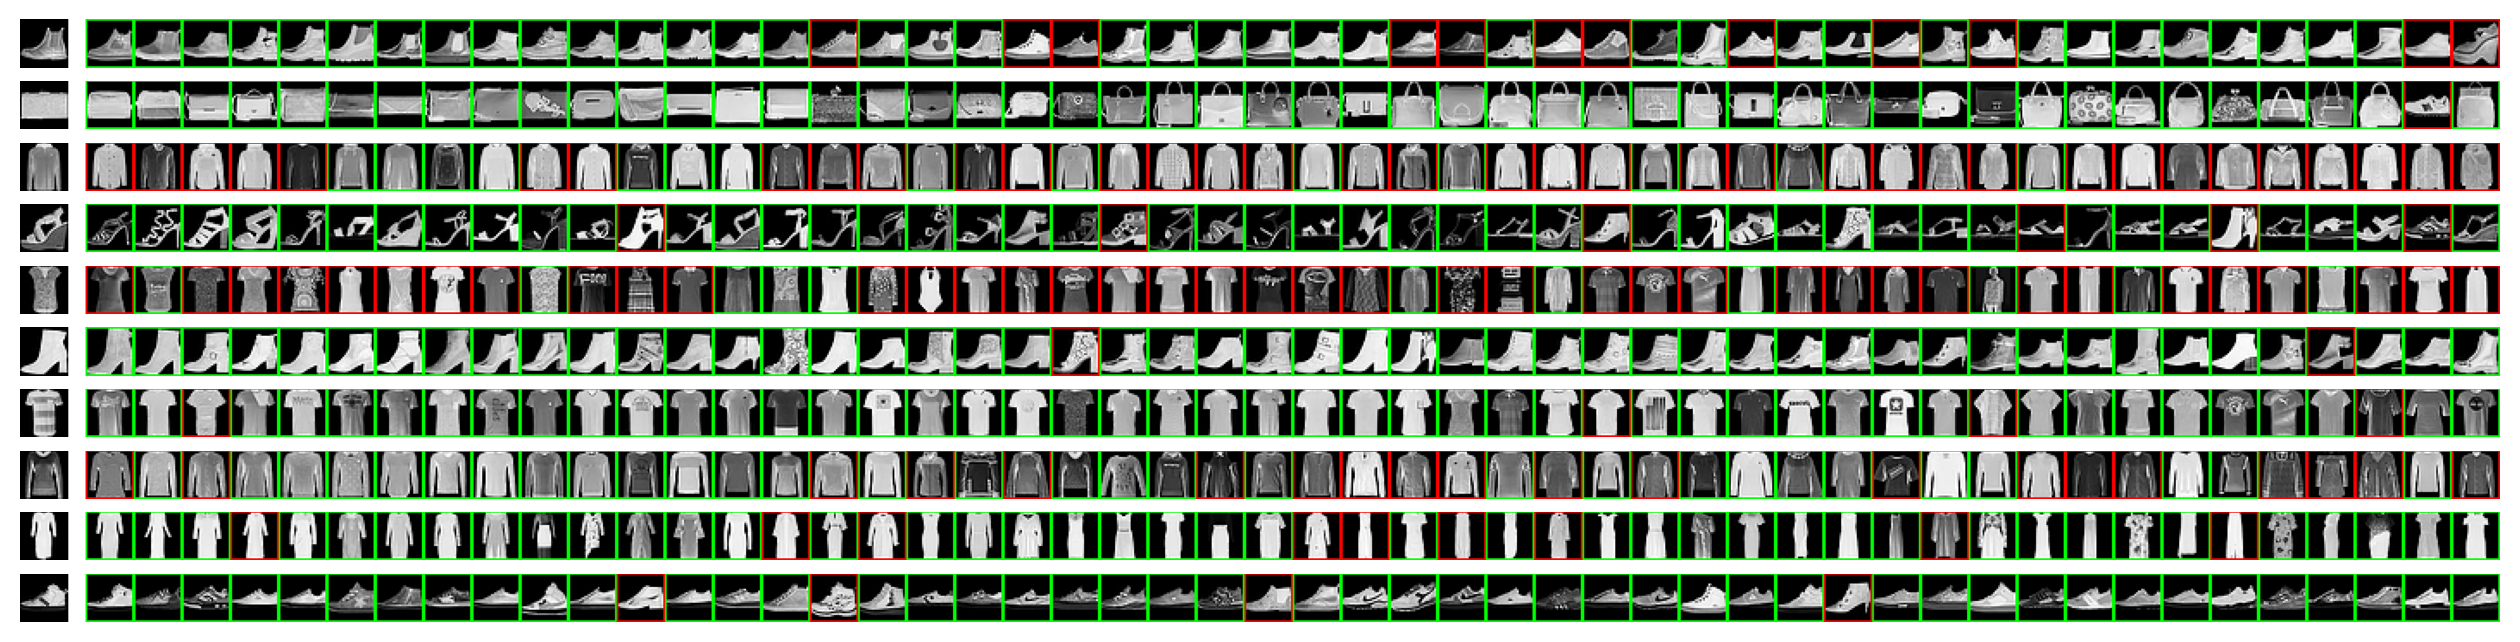

In [58]:
_, num_correct_class = test_retrieval(load_net('net_class'), 'class')

num_correct = array([50, 50,  7, 49, 17, 50, 45, 43, 48, 49])
mAP = tensor f64 0.791


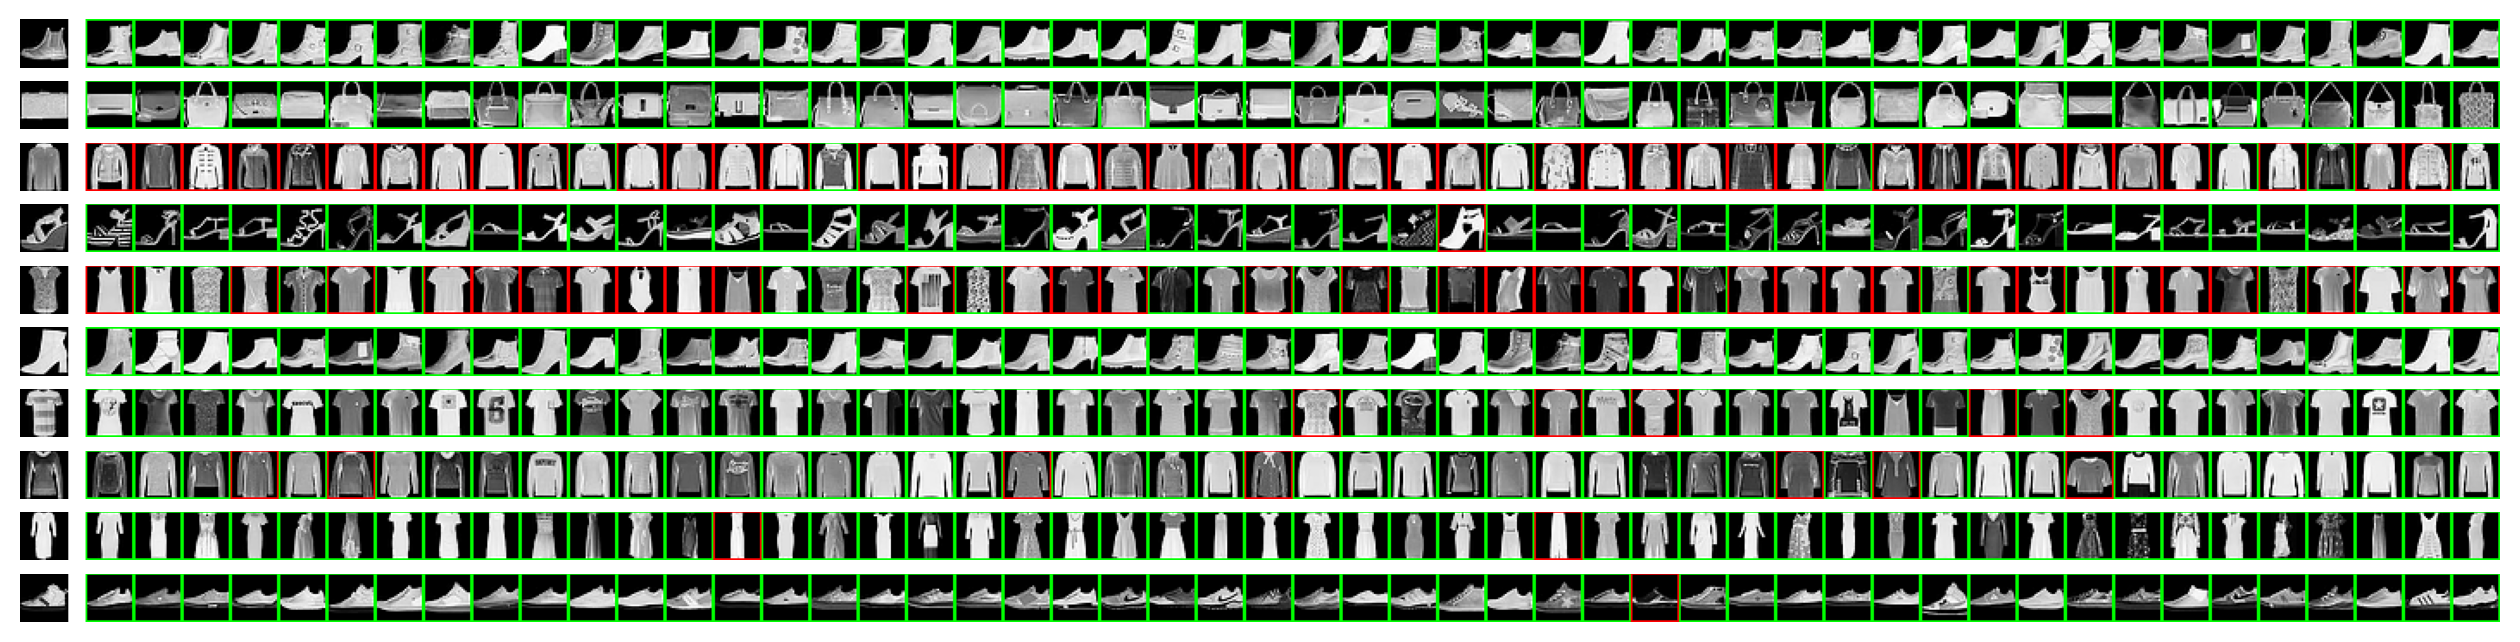

In [59]:
_, num_correct_triplet = test_retrieval(load_net('net_triplet'), 'triplet')

num_correct = array([50, 50, 11, 50, 36, 50, 48, 46, 46, 50])
mAP = tensor f64 0.774


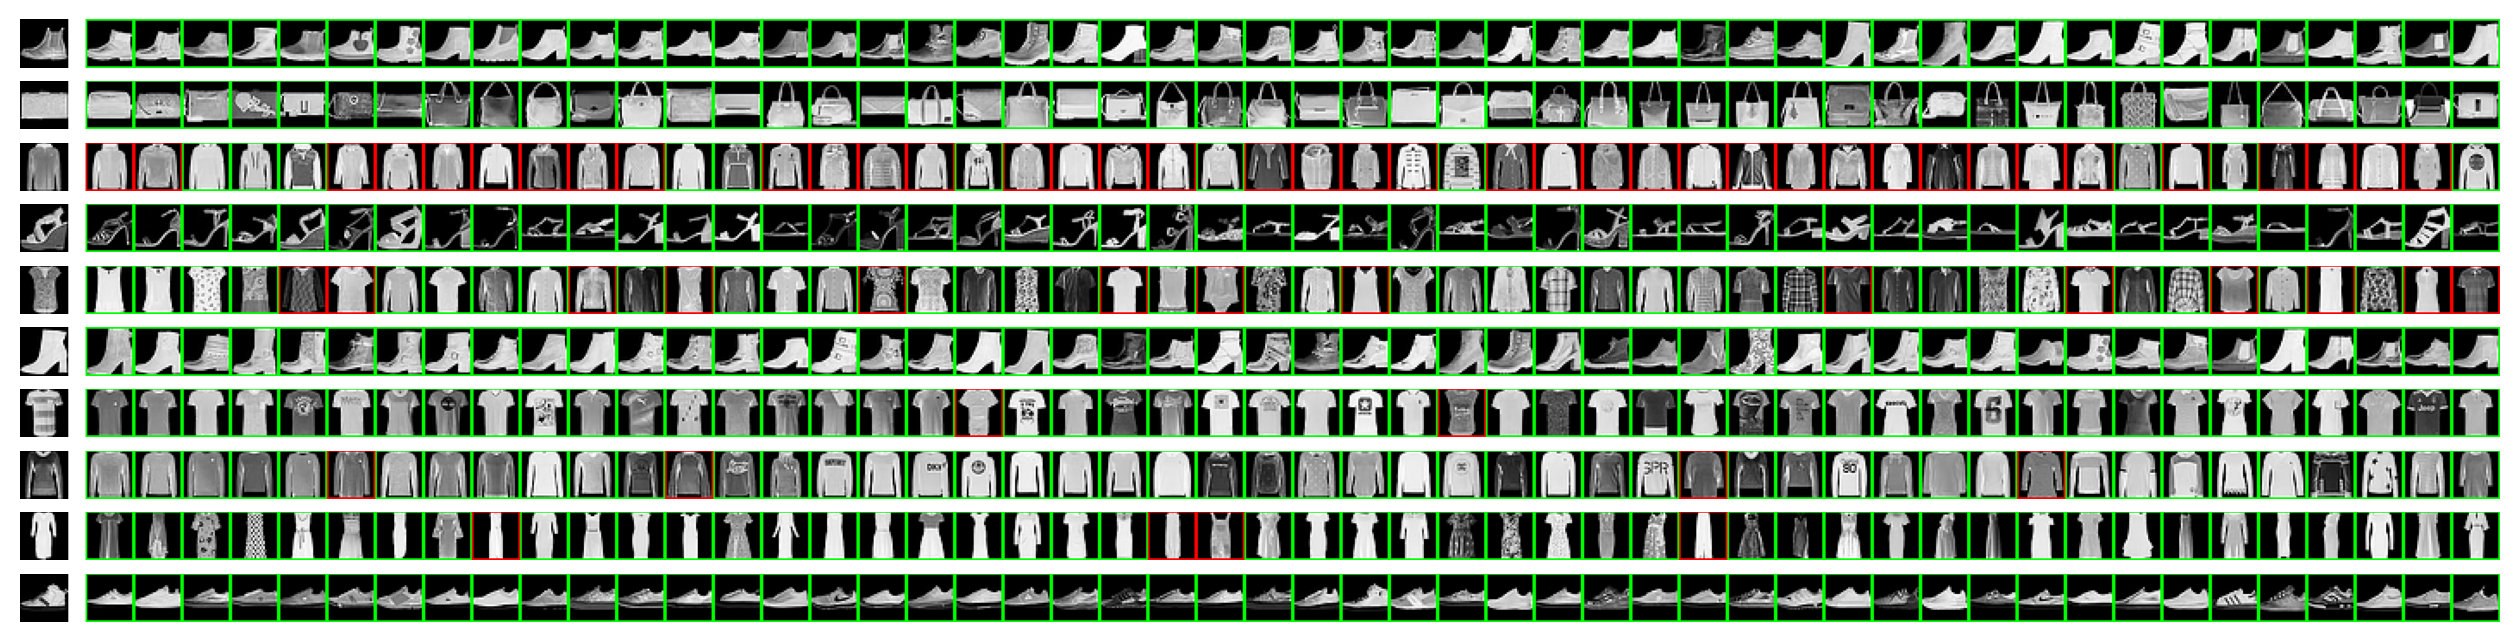

In [60]:
_, num_correct_smoothAP = test_retrieval(load_net('net_smoothAP'), 'smoothAP')

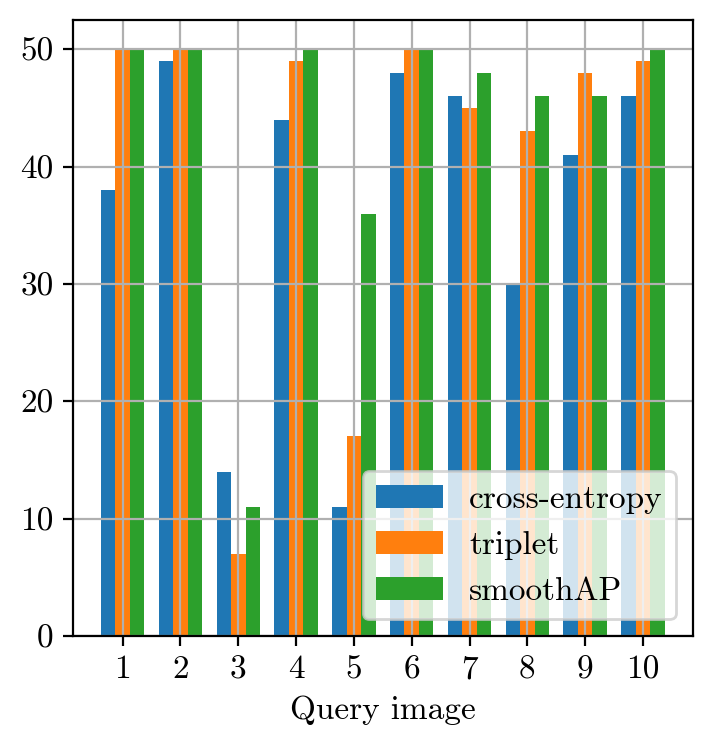

In [66]:
# Plot bar graphs with the number of correct retrievals
x_axis = np.arange(len(query_idxs)) + 1
width = 0.25
fig = plt.figure(figsize=(4, 4), dpi=200)
plt.bar(x_axis - width, num_correct_class, width, label='cross-entropy')
plt.bar(x_axis, num_correct_triplet, width, label='triplet')
plt.bar(x_axis + width, num_correct_smoothAP, width, label='smoothAP')
plt.xlabel('Query image')
plt.grid(True)
plt.xticks(x_axis)
plt.legend(loc='lower right')
save_jpg('figures/correct-retrievals.jpg')

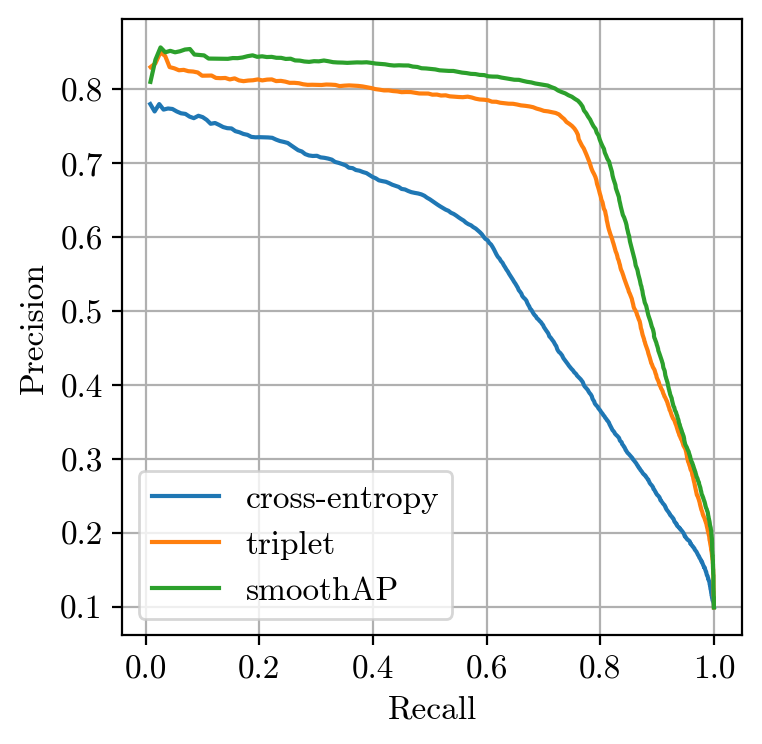

In [62]:
# VoMi: plot Precision vs. Recall for all three models
nets = [
    'triplet',
    'smoothAP'
]

fig = plt.figure(figsize=(4, 4), dpi=200)

mAP, mPrec, mRec = evaluate_mAP(load_net(f'net_class'), test_set)
plt.plot(mRec, mPrec, label=f'cross-entropy')

for loss in nets:
    net = load_net(f'net_{loss}') # load pretrained network
    mAP, mPrec, mRec= evaluate_mAP(net, test_set)
    
    plt.plot(mRec, mPrec, label=f'{loss}')

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
save_jpg('figures/precision-recall.jpg')

# Training stuff

In [65]:
import lab
print(f'{lab.train_set.Y = }')
print(f'{lab.test_set.Y = }')
print(f'{lab.val_set.Y = }')

lab.train_set.Y = tensor[54000] i64 0.4Mb x∈[0, 9] μ=4.501 σ=2.873
lab.test_set.Y = tensor[1000] i64 7.8Kb x∈[0, 9] μ=4.500 σ=2.874
lab.val_set.Y = tensor[6000] i64 47Kb x∈[0, 9] μ=4.491 σ=2.865


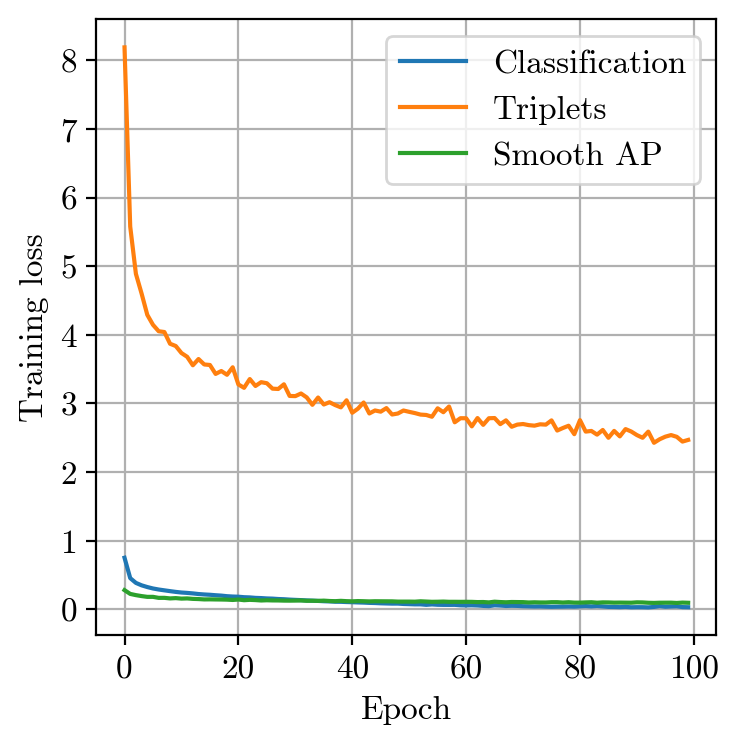

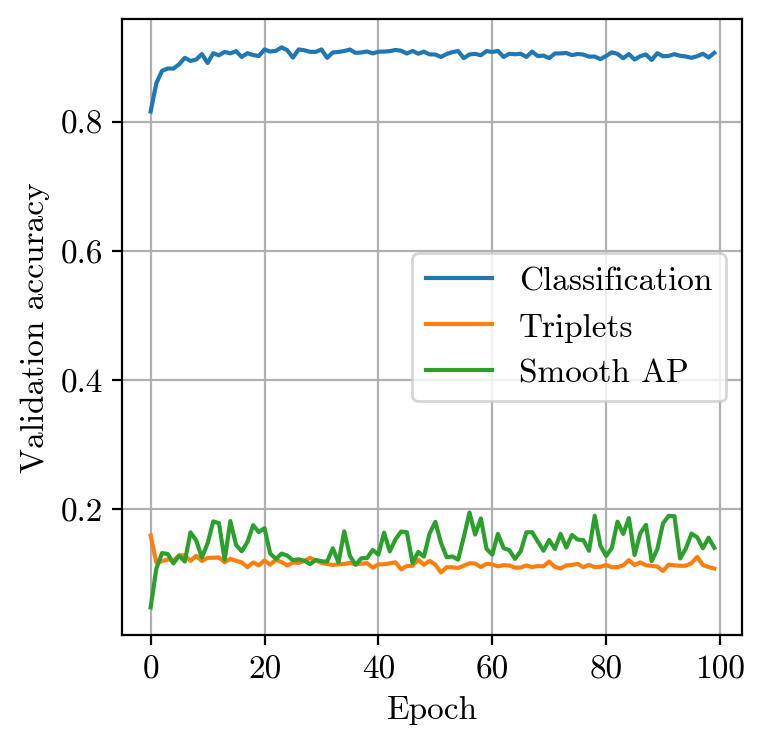

In [71]:
def plot_training_metric(classification, triplets, smooth, metric, ylabel):
    num_epochs = len(triplets[metric])
    plt.plot(classification[metric], label='Classification')
    plt.plot(triplets[metric], label='Triplets')
    plt.plot(smooth[metric], label='Smooth AP')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    save_jpg(f'figures/{metric}.jpg')

import pickle
with open('pickle/net_triplet.pickle', 'rb') as file:
    train_triplets = pickle.load(file)

with open('pickle/net_smoothAP.pickle', 'rb') as file:
    train_smoothAP = pickle.load(file)

with open('pickle/net_class.pickle', 'rb') as file:
    train_class = pickle.load(file)

fig = plt.figure(figsize=(4, 4), dpi=200)
plot_training_metric(train_class, train_triplets, train_smoothAP, 'train-loss', 'Training loss')
fig = plt.figure(figsize=(4, 4), dpi=200)
plot_training_metric(train_class, train_triplets, train_smoothAP, 'val-acc', 'Validation accuracy')
